# Pokemon Data Distributions Analysis

This notebook focuses on exploring the distributions and basic characteristics of the Pokemon dataset. All visualizations use a clean, presentation-ready color palette to highlight key insights about data types and important statistics.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# prevent results from being clipped
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# set up consistent color palette across all notebooks
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")  # 8 colors available

# load the pokemon dataset
df = pd.read_csv('Pokemon Database.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"unique pokemon: {df['Pokemon Name'].nunique()}")

dataset loaded: 1382 rows, 45 columns
unique pokemon: 1025


## Data Overview and Cleaning

In [2]:
# dataset overview table
dataset_overview = pd.DataFrame({
    'metric': ['total rows', 'total columns', 'unique pokemon'],
    'value': [df.shape[0], df.shape[1], df['Pokemon Name'].nunique()]
})
dataset_overview

# column analysis table
column_info = []
for col in df.columns:
    column_info.append({
        'column': col,
        'data type': str(df[col].dtype),
        'missing values': df[col].isnull().sum()
    })
column_analysis = pd.DataFrame(column_info)
column_analysis

# select relevant columns - expanded to include physical characteristics, abilities, and ev stats
relevant_cols = [
    'Pokedex Number', 'Pokemon Name', 'Classification',
    'Primary Type', 'Secondary Type', 'Legendary Type',
    'Pokemon Height', 'Pokemon Weight',
    'Primary Ability', 'Secondary Ability', 'Hidden Ability',
    'Health Stat', 'Attack Stat', 'Defense Stat', 
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total',
    'Health EV', 'Attack EV', 'Defense EV', 
    'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total',
    'Catch Rate', 'Base Happiness',
    'Male Ratio', 'Female Ratio',
    'Primary Egg Group', 'Secondary Egg Group'
]

df_clean = df[relevant_cols].copy()

# handle missing values
df_clean['Secondary Type'] = df_clean['Secondary Type'].fillna('None')
df_clean['Legendary Type'] = df_clean['Legendary Type'].fillna('Normal')
df_clean['Secondary Ability'] = df_clean['Secondary Ability'].fillna('None')
df_clean['Hidden Ability'] = df_clean['Hidden Ability'].fillna('None')
df_clean['Secondary Egg Group'] = df_clean['Secondary Egg Group'].fillna('None')

# fill numeric missing values with 0 or median where appropriate
df_clean['Pokemon Height'] = df_clean['Pokemon Height'].fillna(df_clean['Pokemon Height'].median())
df_clean['Pokemon Weight'] = df_clean['Pokemon Weight'].fillna(df_clean['Pokemon Weight'].median())
df_clean['Male Ratio'] = df_clean['Male Ratio'].fillna(-1)  # -1 indicates genderless
df_clean['Female Ratio'] = df_clean['Female Ratio'].fillna(-1)
df_clean['Base Happiness'] = df_clean['Base Happiness'].fillna(df_clean['Base Happiness'].median())

# remove duplicates by pokedex number, keeping the LAST entry (newest game stats)
df_clean = df_clean.sort_index().drop_duplicates(subset=['Pokedex Number'], keep='last')

# add derived features for analysis
df_clean['Is Legendary'] = (df_clean['Legendary Type'] != 'Normal').astype(int)
df_clean['Has Secondary Type'] = (df_clean['Secondary Type'] != 'None').astype(int)
df_clean['Has Secondary Ability'] = (df_clean['Secondary Ability'] != 'None').astype(int)
df_clean['Has Hidden Ability'] = (df_clean['Hidden Ability'] != 'None').astype(int)

# calculate additional derived features
df_clean['BMI'] = df_clean['Pokemon Weight'] / (df_clean['Pokemon Height'] ** 2)  # weight/height^2
df_clean['Physical Offense'] = df_clean['Attack Stat'] + df_clean['Speed Stat']
df_clean['Physical Defense'] = df_clean['Defense Stat'] + df_clean['Health Stat']
df_clean['Special Offense'] = df_clean['Special Attack Stat'] + df_clean['Speed Stat']
df_clean['Special Defense Total'] = df_clean['Special Defense Stat'] + df_clean['Health Stat']
df_clean['Offensive Total'] = df_clean['Attack Stat'] + df_clean['Special Attack Stat']
df_clean['Defensive Total'] = df_clean['Defense Stat'] + df_clean['Special Defense Stat']
df_clean['Stat Variance'] = df_clean[['Health Stat', 'Attack Stat', 'Defense Stat', 
                                        'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']].var(axis=1)

print(f"cleaned dataset: {df_clean.shape[0]} pokemon, {df_clean.shape[1]} features")
print(f"legendary pokemon: {df_clean['Is Legendary'].sum()}")
print(f"pokemon with secondary types: {df_clean['Has Secondary Type'].sum()}")
print(f"pokemon with secondary abilities: {df_clean['Has Secondary Ability'].sum()}")
print(f"pokemon with hidden abilities: {df_clean['Has Hidden Ability'].sum()}")

# display feature categories
print("\nfeature categories:")
print(f"• identification: pokedex number, name, classification")
print(f"• types: primary type, secondary type, legendary type")
print(f"• physical: height, weight, bmi")
print(f"• abilities: primary, secondary, hidden")
print(f"• base stats: hp, atk, def, sp.atk, sp.def, speed, total")
print(f"• ev yields: hp, atk, def, sp.atk, sp.def, speed, total")
print(f"• game mechanics: catch rate, base happiness")
print(f"• breeding: male/female ratios, egg groups")
print(f"• derived features: stat variance, offensive/defensive totals, etc.")

# save the cleaned dataset for use in other notebooks
df_clean.to_csv('pokemon_cleaned.csv', index=False)
print("\ncleaned dataset saved as 'pokemon_cleaned.csv'")


cleaned dataset: 1025 pokemon, 43 features
legendary pokemon: 103
pokemon with secondary types: 560
pokemon with secondary abilities: 502
pokemon with hidden abilities: 804

feature categories:
• identification: pokedex number, name, classification
• types: primary type, secondary type, legendary type
• physical: height, weight, bmi
• abilities: primary, secondary, hidden
• base stats: hp, atk, def, sp.atk, sp.def, speed, total
• ev yields: hp, atk, def, sp.atk, sp.def, speed, total
• game mechanics: catch rate, base happiness
• breeding: male/female ratios, egg groups
• derived features: stat variance, offensive/defensive totals, etc.

cleaned dataset saved as 'pokemon_cleaned.csv'


In [3]:
# show what columns were excluded and what columns were added
original_cols = set(df.columns)
kept_cols = set(relevant_cols)
excluded_cols = sorted(original_cols - kept_cols)

# newly computed columns
computed_cols = [
    'Is Legendary', 'Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability',
    'BMI', 'Physical Offense', 'Physical Defense', 'Special Offense', 
    'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance'
]

print("columns excluded from original dataset:")
for col in excluded_cols:
    print(f"  • {col}")
print(f"\ntotal excluded: {len(excluded_cols)} columns")

print("\nnewly computed columns added:")
for col in computed_cols:
    print(f"  • {col}")
print(f"\ntotal computed: {len(computed_cols)} columns")

print(f"\noriginal dataset: {len(original_cols)} columns")
print(f"kept from original: {len(kept_cols)} columns")
print(f"final dataset: {len(kept_cols) + len(computed_cols)} columns")

columns excluded from original dataset:
  • Alternate Form Name
  • Egg Cycle Count
  • Evolution Details
  • Experience Growth
  • Experience Growth Total
  • Game(s) of Origin
  • Hidden Ability Description
  • Original Pokemon ID
  • Pokemon Id
  • Pre-Evolution Pokemon Id
  • Primary Ability Description
  • Secondary Ability Description
  • Special Event Ability
  • Special Event Ability Description

total excluded: 14 columns

newly computed columns added:
  • Is Legendary
  • Has Secondary Type
  • Has Secondary Ability
  • Has Hidden Ability
  • BMI
  • Physical Offense
  • Physical Defense
  • Special Offense
  • Special Defense Total
  • Offensive Total
  • Defensive Total
  • Stat Variance

total computed: 12 columns

original dataset: 45 columns
kept from original: 31 columns
final dataset: 43 columns


## Type Distributions

single-type pokemon: 465
dual-type pokemon: 560


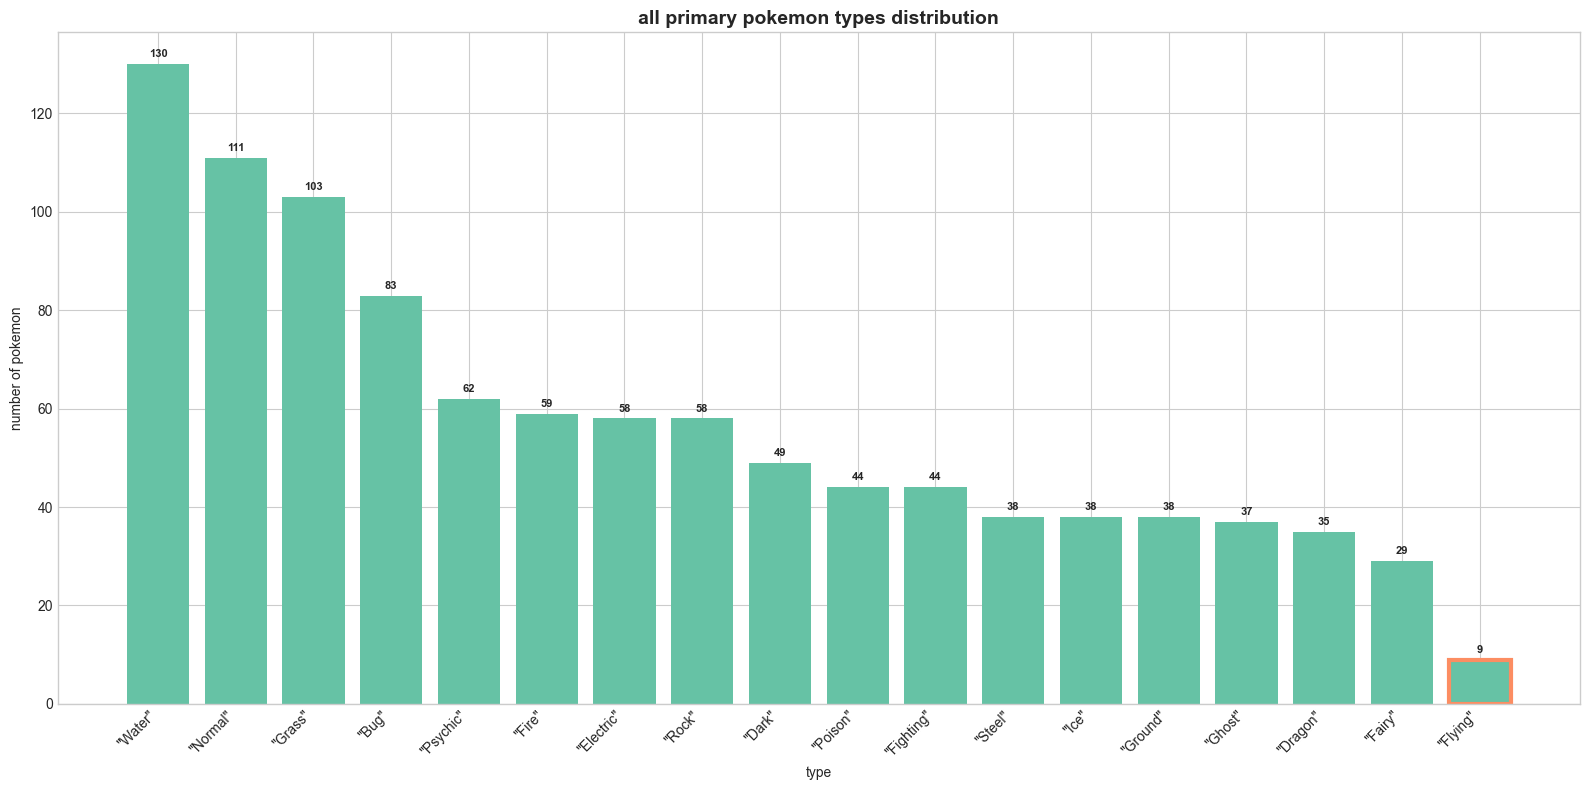

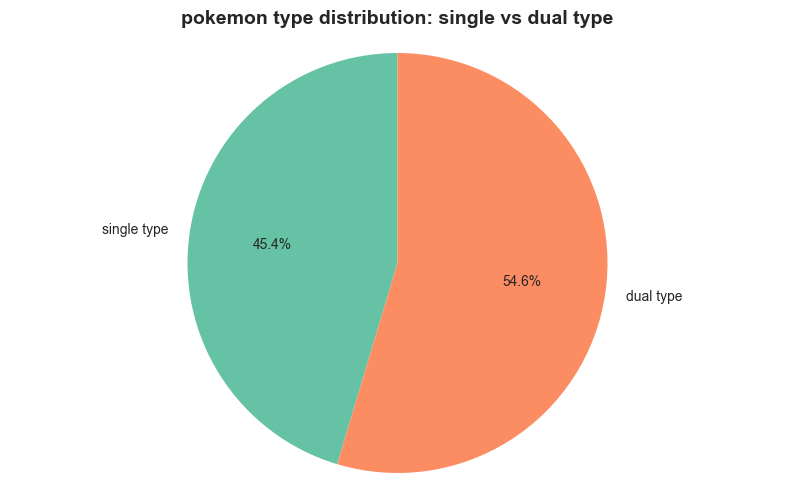

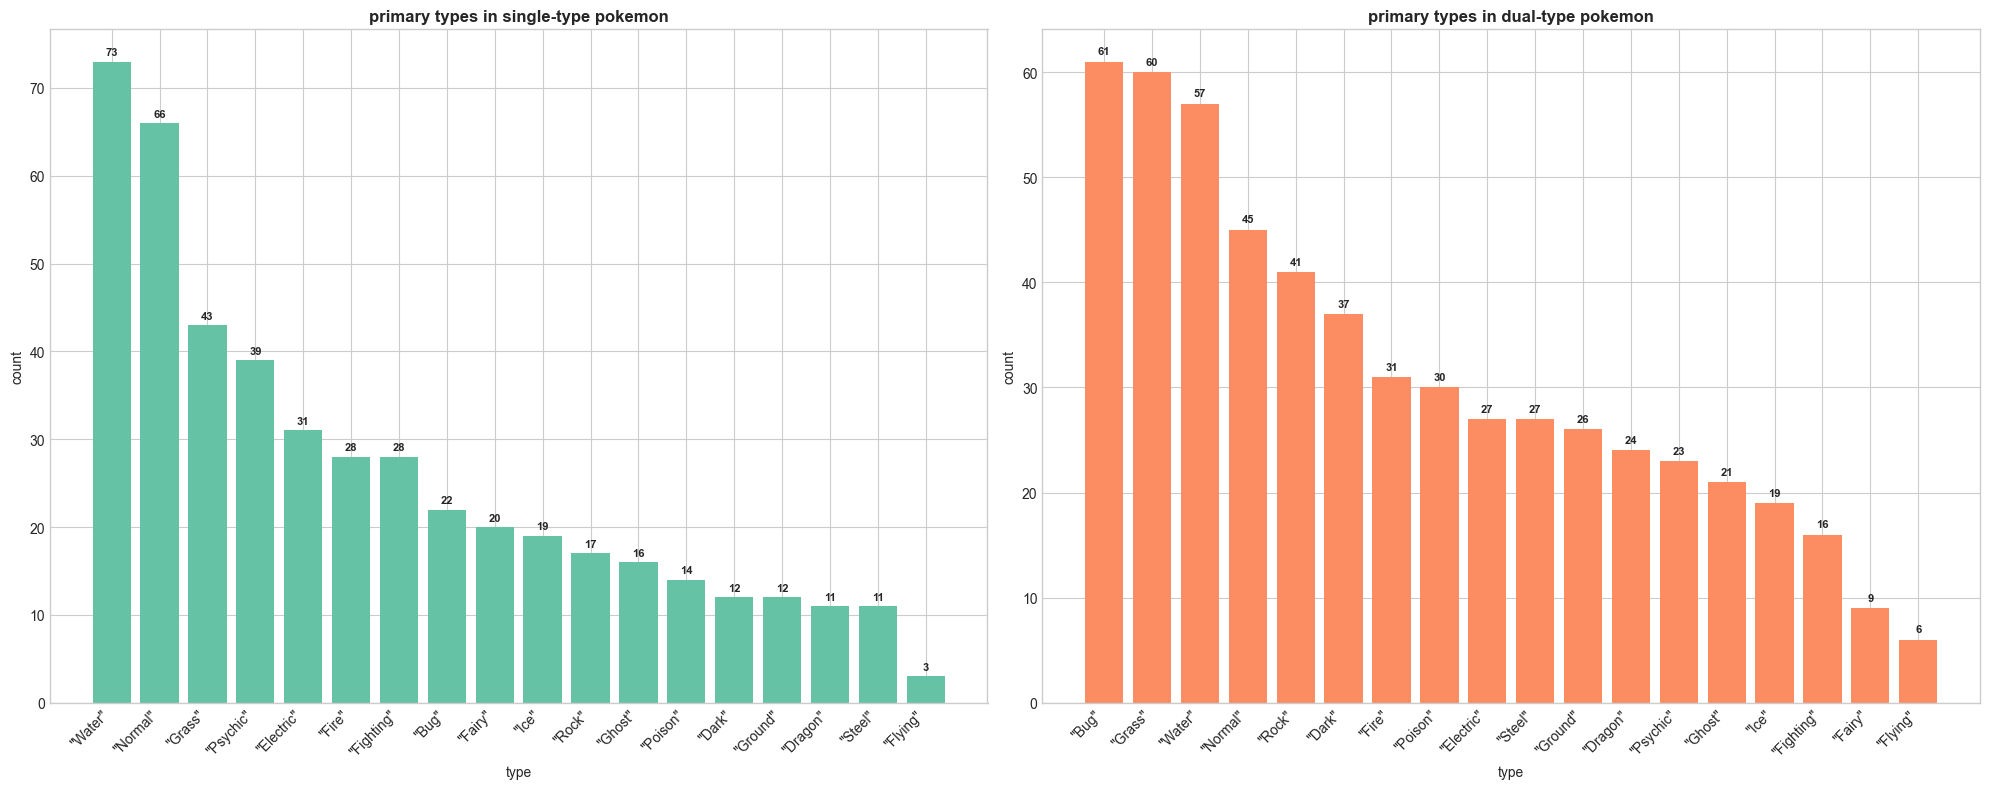

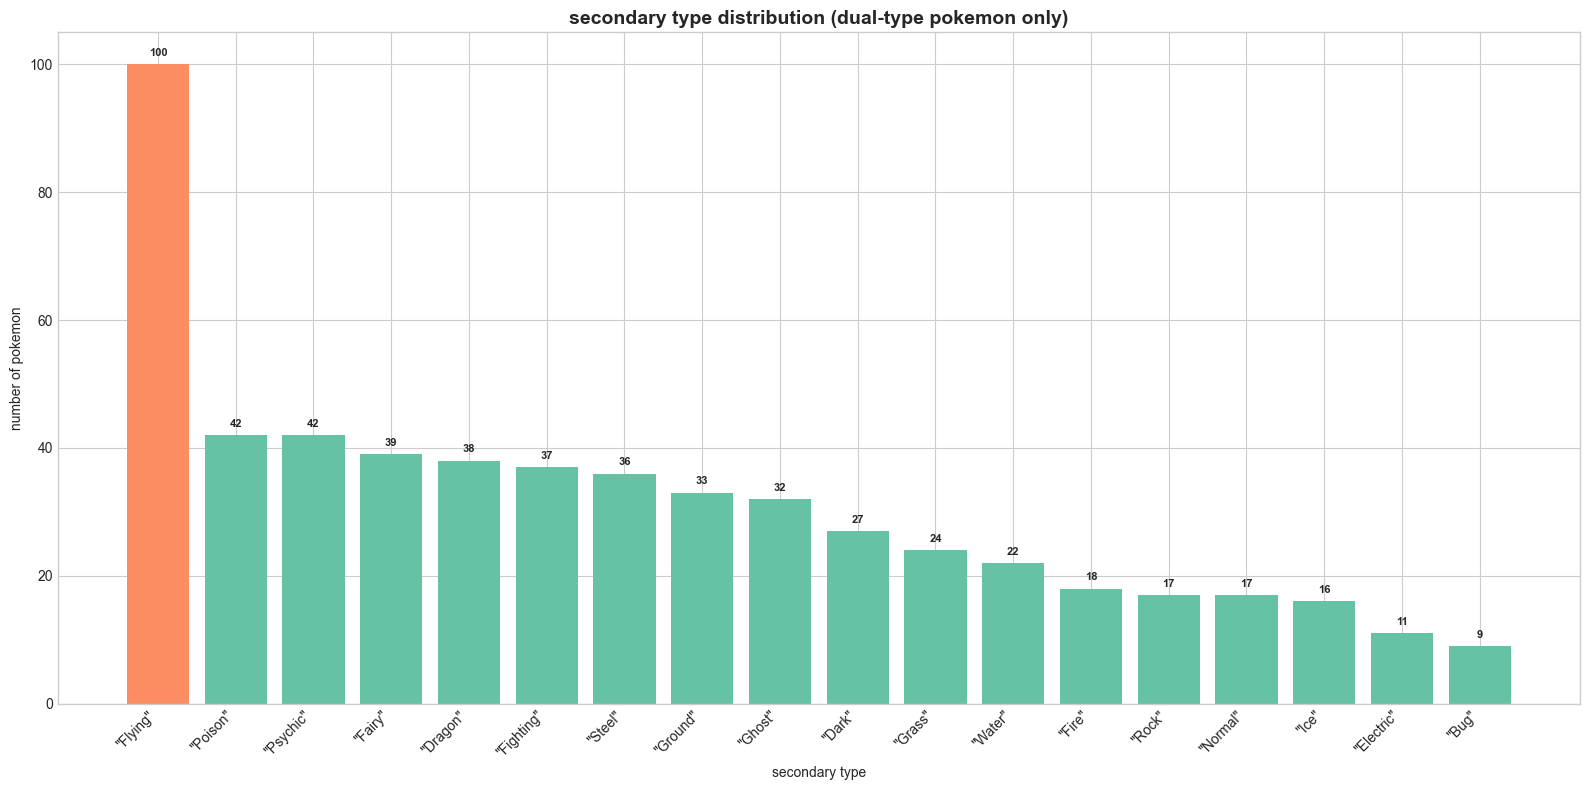

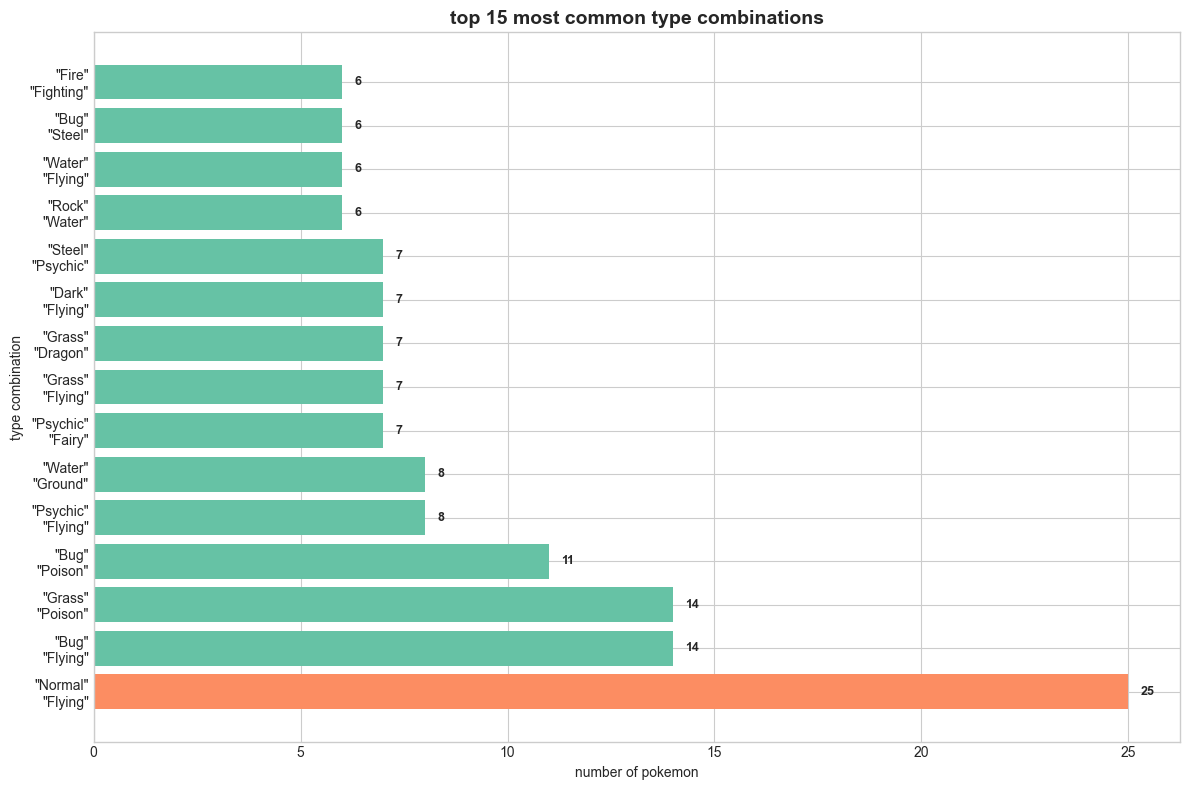

In [4]:
# separate single-type and dual-type pokemon
single_type = df_clean[df_clean['Secondary Type'] == 'None']
dual_type = df_clean[df_clean['Secondary Type'] != 'None']

print(f"single-type pokemon: {len(single_type)}")
print(f"dual-type pokemon: {len(dual_type)}")

# primary type distribution - all types
plt.figure(figsize=(16, 8))
all_type_counts = df_clean['Primary Type'].value_counts()
# highlight flying type (unusually low for primary) with orange outline
colors = [presentation_palette[0] if type_name != '\"Flying\"' else presentation_palette[0] for type_name in all_type_counts.index]
edgecolors = ['none' if type_name != '\"Flying\"' else presentation_palette[1] for type_name in all_type_counts.index]
linewidths = [0 if type_name != '\"Flying\"' else 3 for type_name in all_type_counts.index]
bars = plt.bar(range(len(all_type_counts)), all_type_counts.values, color=colors, edgecolor=edgecolors, linewidth=linewidths)
plt.xticks(range(len(all_type_counts)), all_type_counts.index, rotation=45, ha='right')
plt.title('all primary pokemon types distribution', fontsize=14, fontweight='bold')
plt.ylabel('number of pokemon')
plt.xlabel('type')

# add value labels on bars
for bar, count in zip(bars, all_type_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/distribution/primary_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# single vs dual type distribution
plt.figure(figsize=(10, 6))
type_dist = [len(single_type), len(dual_type)]
labels = ['single type', 'dual type']
plt.pie(type_dist, labels=labels, autopct='%1.1f%%',
        colors=[presentation_palette[0], presentation_palette[1]], startangle=90)
plt.title('pokemon type distribution: single vs dual type', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.savefig('figures/distribution/single_vs_dual_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# primary types for single vs dual type pokemon
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# single type primary types
single_primary = single_type['Primary Type'].value_counts()
bars1 = ax1.bar(range(len(single_primary)), single_primary.values, color=presentation_palette[0])
ax1.set_xticks(range(len(single_primary)))
ax1.set_xticklabels(single_primary.index, rotation=45, ha='right')
ax1.set_title('primary types in single-type pokemon', fontweight='bold')
ax1.set_ylabel('count')
ax1.set_xlabel('type')

# add value labels on bars
for bar, count in zip(bars1, single_primary.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# dual type primary types
dual_primary = dual_type['Primary Type'].value_counts()
bars2 = ax2.bar(range(len(dual_primary)), dual_primary.values, color=presentation_palette[1])
ax2.set_xticks(range(len(dual_primary)))
ax2.set_xticklabels(dual_primary.index, rotation=45, ha='right')
ax2.set_title('primary types in dual-type pokemon', fontweight='bold')
ax2.set_ylabel('count')
ax2.set_xlabel('type')

# add value labels on bars
for bar, count in zip(bars2, dual_primary.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/distribution/primary_types_single_vs_dual.png', dpi=300, bbox_inches='tight')
plt.show()

# secondary type distribution (for dual-type pokemon only)
plt.figure(figsize=(16, 8))
secondary_counts = dual_type['Secondary Type'].value_counts()
# highlight flying type (most common secondary) with orange
colors = [presentation_palette[1] if type_name == '\"Flying\"' else presentation_palette[0] for type_name in secondary_counts.index]
bars = plt.bar(range(len(secondary_counts)), secondary_counts.values, color=colors)
plt.xticks(range(len(secondary_counts)), secondary_counts.index, rotation=45, ha='right')
plt.title('secondary type distribution (dual-type pokemon only)', fontsize=14, fontweight='bold')
plt.ylabel('number of pokemon')
plt.xlabel('secondary type')

for bar, count in zip(bars, secondary_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/distribution/secondary_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# most common type combinations
combinations = dual_type.groupby(['Primary Type', 'Secondary Type']).size().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
# highlight top combination with orange, rest with teal
colors = [presentation_palette[1] if i == 0 else presentation_palette[0] for i in range(len(combinations))]
bars = plt.barh(range(len(combinations)), combinations.values, color=colors)
plt.yticks(range(len(combinations)), [f"{primary}\n{secondary}" for primary, secondary in combinations.index])
plt.title('top 15 most common type combinations', fontsize=14, fontweight='bold')
plt.xlabel('number of pokemon')
plt.ylabel('type combination')

# add value labels on bars
for i, (bar, count) in enumerate(zip(bars, combinations.values)):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{count}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/distribution/top_type_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

## Base Stat Distributions

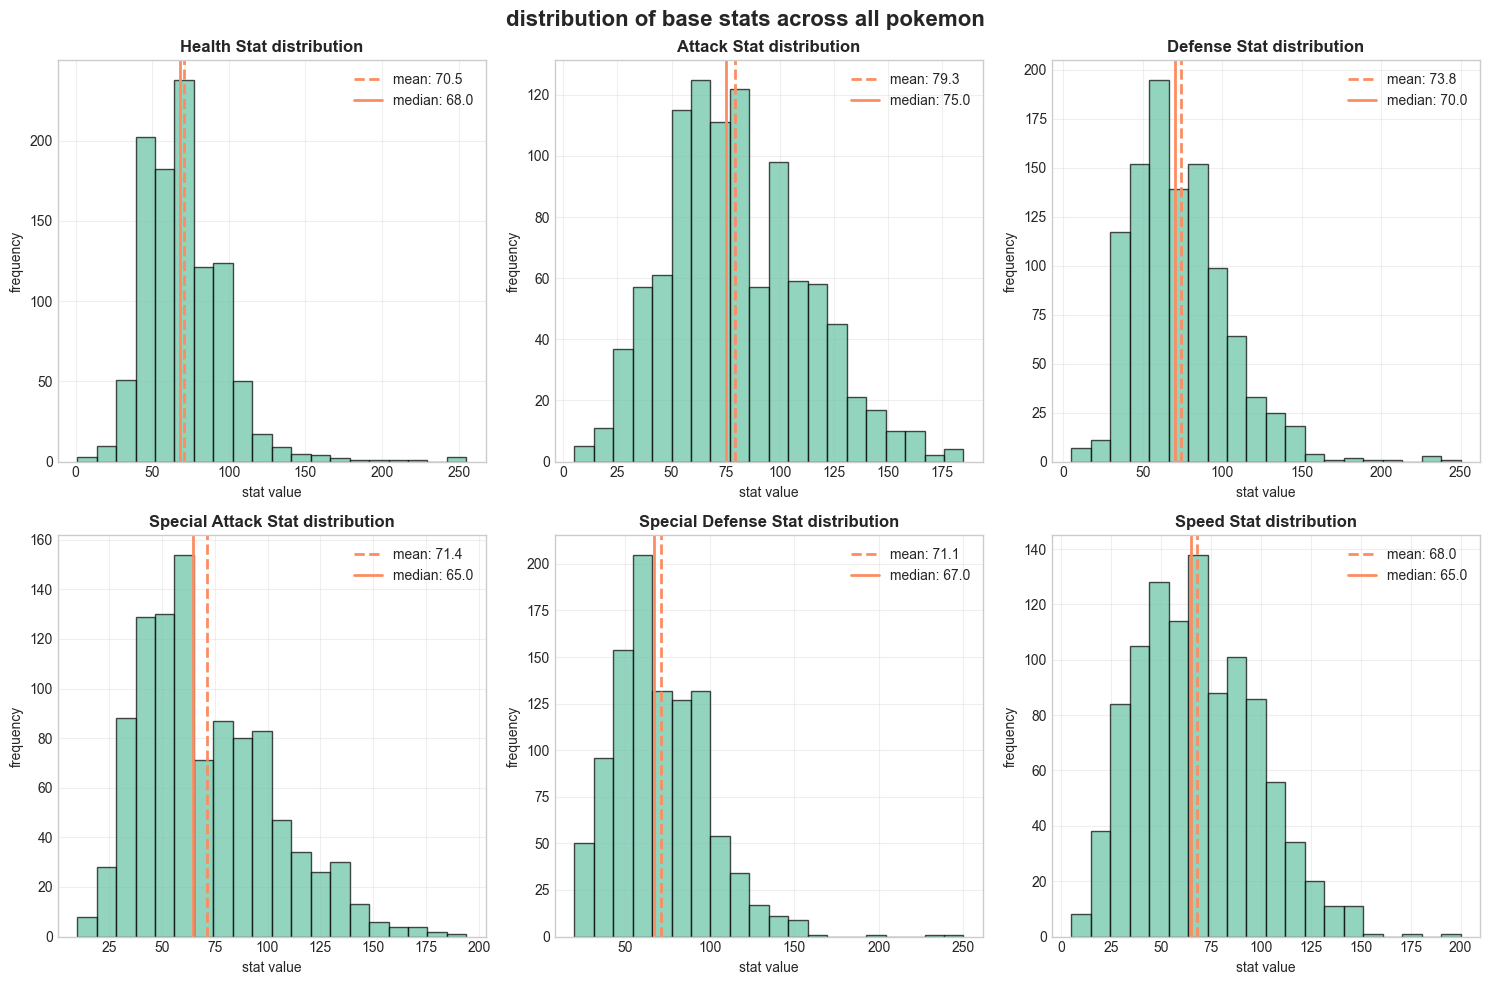

base stat summary statistics:


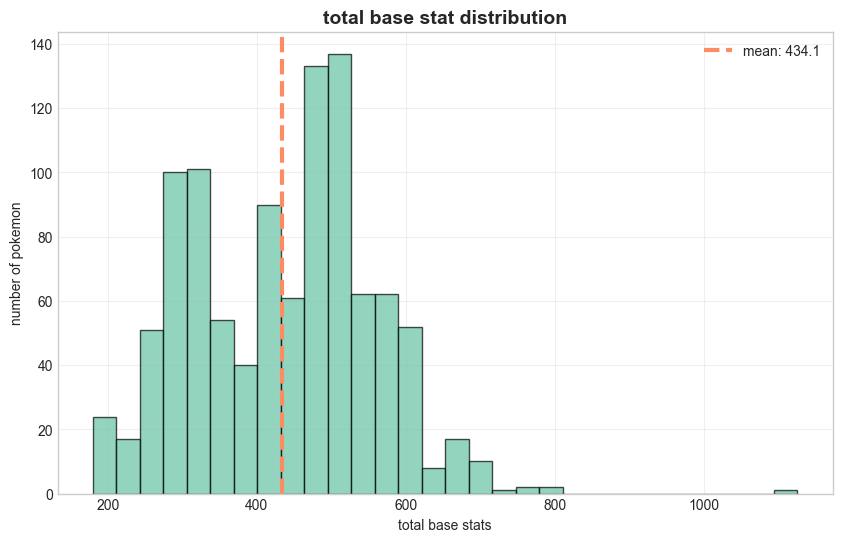

total base stats summary


,metric,value
0,average total stats,434.1
1,minimum total stats,180.0
2,maximum total stats,1125.0
3,standard deviation,120.6


In [5]:
stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']

# individual stat distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('distribution of base stats across all pokemon', fontsize=16, fontweight='bold')

for i, stat in enumerate(stats_cols):
    row, col = i // 3, i % 3
    axes[row, col].hist(df_clean[stat], bins=20, alpha=0.7, color=presentation_palette[0], edgecolor='black')
    axes[row, col].axvline(df_clean[stat].mean(), color=presentation_palette[1], linestyle='--', linewidth=2, label=f'mean: {df_clean[stat].mean():.1f}')
    axes[row, col].axvline(df_clean[stat].median(), color=presentation_palette[1], linestyle='-', linewidth=2, label=f'median: {df_clean[stat].median():.1f}')
    axes[row, col].set_title(f'{stat} distribution', fontweight='bold')
    axes[row, col].set_xlabel('stat value')
    axes[row, col].set_ylabel('frequency')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/distribution/base_stats_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# summary statistics table
print("base stat summary statistics:")
stats_summary = df_clean[stats_cols].describe().round(1)
stats_summary

# total base stat distribution
plt.figure(figsize=(10, 6))
plt.hist(df_clean['Base Stat Total'], bins=30, alpha=0.7, color=presentation_palette[0], edgecolor='black')
plt.axvline(df_clean['Base Stat Total'].mean(), color=presentation_palette[1], linestyle='--', linewidth=3,
            label=f'mean: {df_clean["Base Stat Total"].mean():.1f}')
plt.title('total base stat distribution', fontsize=14, fontweight='bold')
plt.xlabel('total base stats')
plt.ylabel('number of pokemon')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/distribution/total_base_stat_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# total stats summary table
total_stats_summary = pd.DataFrame({
    'metric': [
        'average total stats',
        'minimum total stats',
        'maximum total stats',
        'standard deviation'
    ],
    'value': [
        round(df_clean['Base Stat Total'].mean(), 1),
        df_clean['Base Stat Total'].min(),
        df_clean['Base Stat Total'].max(),
        round(df_clean['Base Stat Total'].std(), 1)
    ]
})
print("total base stats summary")
total_stats_summary

## Legendary vs Normal Pokemon Comparison

average stats: normal vs legendary pokemon


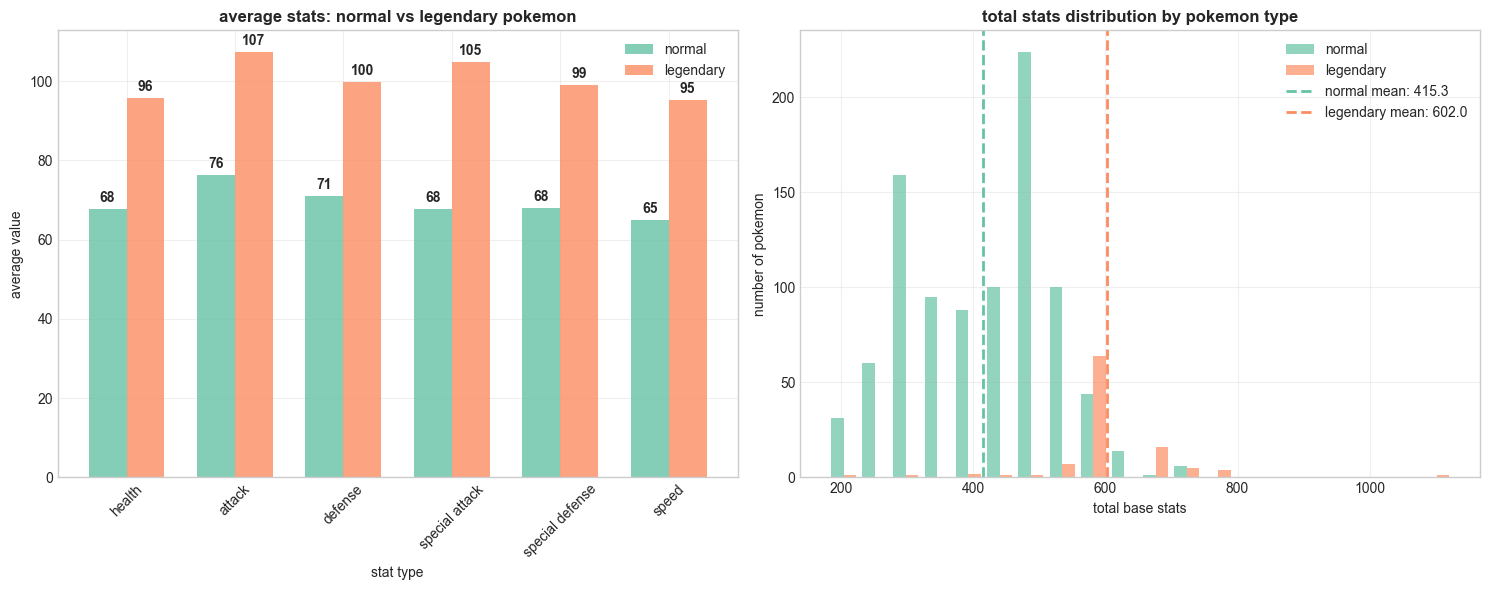


legendary pokemon have on average 186.7 more total stats than normal pokemon
strongest legendary stat boost: special attack stat (+37.3)

outlier analysis:
"Eternatus" ("Legendary")
total stats: 1125
this is 545.0 points above the median legendary pokemon


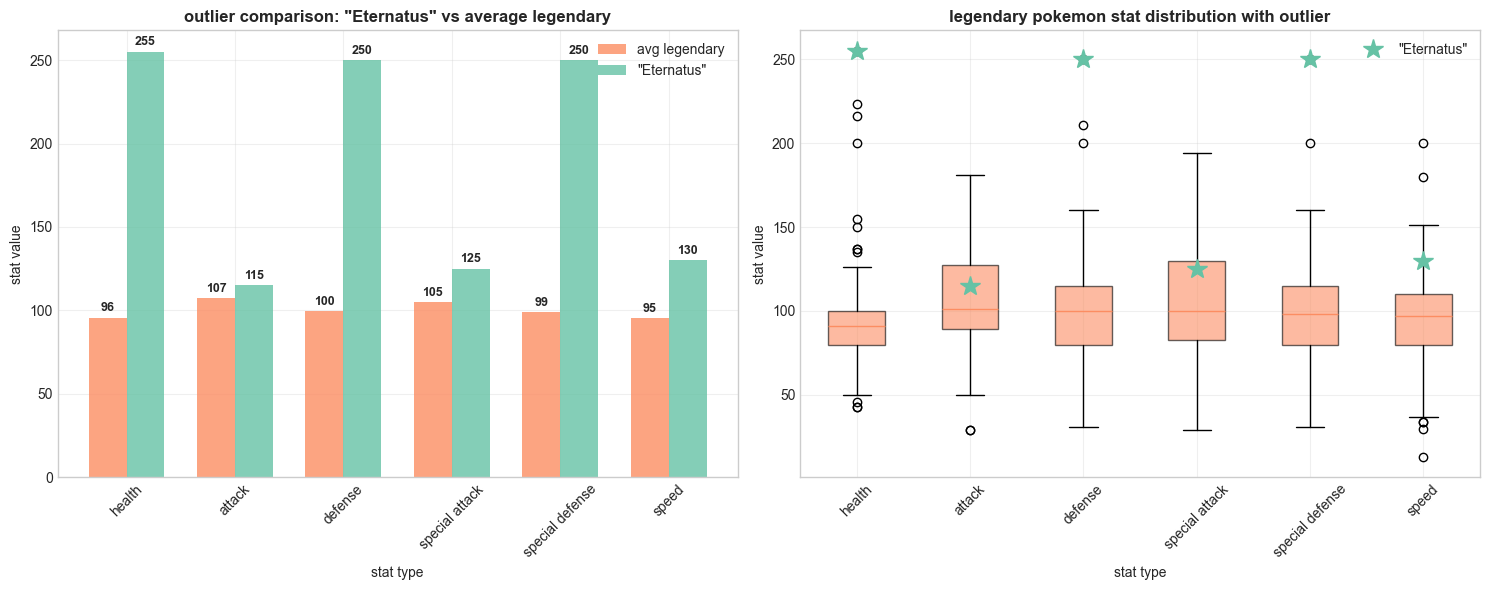


legendary vs normal pokemon summary


,metric,value
0,legendary advantage (total stats),+186.7 total stats
1,strongest legendary stat boost,special attack stat
2,stat boost amount,+37.3
3,legendary pokemon count,103
4,normal pokemon count,922


In [6]:
# compare legendary vs normal pokemon stats
legendary_stats = df_clean[df_clean['Is Legendary'] == 1][stats_cols].mean()
normal_stats = df_clean[df_clean['Is Legendary'] == 0][stats_cols].mean()

comparison_df = pd.DataFrame({
    'normal pokemon': normal_stats,
    'legendary pokemon': legendary_stats,
    'difference': legendary_stats - normal_stats
}).round(1)

print("average stats: normal vs legendary pokemon")
comparison_df

# visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# bar chart comparison
x = np.arange(len(stats_cols))
width = 0.35

bars1 = axes[0].bar(x - width/2, normal_stats, width, label='normal', color=presentation_palette[0], alpha=0.8)
bars2 = axes[0].bar(x + width/2, legendary_stats, width, label='legendary', color=presentation_palette[1], alpha=0.8)

axes[0].set_xlabel('stat type')
axes[0].set_ylabel('average value')
axes[0].set_title('average stats: normal vs legendary pokemon', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([stat.replace(' Stat', '').lower() for stat in stats_cols], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

# total stats distribution by legendary status
legendary_totals = df_clean[df_clean['Is Legendary'] == 1]['Base Stat Total']
normal_totals = df_clean[df_clean['Is Legendary'] == 0]['Base Stat Total']

axes[1].hist([normal_totals, legendary_totals], bins=20, alpha=0.7,
             label=['normal', 'legendary'], color=[presentation_palette[0], presentation_palette[1]])
axes[1].axvline(normal_totals.mean(), color=presentation_palette[0], linestyle='--', linewidth=2,
                label=f'normal mean: {normal_totals.mean():.1f}')
axes[1].axvline(legendary_totals.mean(), color=presentation_palette[1], linestyle='--', linewidth=2,
                label=f'legendary mean: {legendary_totals.mean():.1f}')
axes[1].set_xlabel('total base stats')
axes[1].set_ylabel('number of pokemon')
axes[1].set_title('total stats distribution by pokemon type', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/distribution/legendary_vs_normal_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nlegendary pokemon have on average {legendary_totals.mean() - normal_totals.mean():.1f} more total stats than normal pokemon")
print(f"strongest legendary stat boost: {comparison_df['difference'].idxmax().lower()} (+{comparison_df['difference'].max():.1f})")

# outlier analysis - separate visualization
legendary_pokemon = df_clean[df_clean['Is Legendary'] == 1][['Pokemon Name', 'Base Stat Total', 'Legendary Type'] + stats_cols]
max_stat_pokemon = legendary_pokemon.loc[legendary_pokemon['Base Stat Total'].idxmax()]

print(f"\noutlier analysis:")
print(f"{max_stat_pokemon['Pokemon Name']} ({max_stat_pokemon['Legendary Type']})")
print(f"total stats: {max_stat_pokemon['Base Stat Total']}")
print(f"this is {max_stat_pokemon['Base Stat Total'] - legendary_totals.median():.1f} points above the median legendary pokemon")

# create separate visualization for outlier
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# bar chart showing outlier stats vs average legendary
outlier_stats = [max_stat_pokemon[stat] for stat in stats_cols]
avg_legendary = [legendary_stats[stat] for stat in stats_cols]

x = np.arange(len(stats_cols))
width = 0.35

bars1 = ax1.bar(x - width/2, avg_legendary, width, label='avg legendary', color=presentation_palette[1], alpha=0.8)
bars2 = ax1.bar(x + width/2, outlier_stats, width, label=f'{max_stat_pokemon["Pokemon Name"]}', color=presentation_palette[0], alpha=0.8)

ax1.set_xlabel('stat type')
ax1.set_ylabel('stat value')
ax1.set_title(f'outlier comparison: {max_stat_pokemon["Pokemon Name"]} vs average legendary', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([stat.replace(' Stat', '').lower() for stat in stats_cols], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# boxplot showing outlier in context
legendary_stats_list = [legendary_pokemon[stat].values for stat in stats_cols]
bp = ax2.boxplot(legendary_stats_list, labels=[stat.replace(' Stat', '').lower() for stat in stats_cols],
                 patch_artist=True, showfliers=True)

for patch in bp['boxes']:
    patch.set_facecolor(presentation_palette[1])
    patch.set_alpha(0.6)

# highlight outlier points in teal
for i, stat in enumerate(stats_cols):
    outlier_value = max_stat_pokemon[stat]
    ax2.plot(i + 1, outlier_value, '*', color=presentation_palette[0], markersize=15, label=f'{max_stat_pokemon["Pokemon Name"]}' if i == 0 else '')

ax2.set_xlabel('stat type')
ax2.set_ylabel('stat value')
ax2.set_title('legendary pokemon stat distribution with outlier', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('figures/distribution/legendary_outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# legendary comparison summary table
legendary_comparison_summary = pd.DataFrame({
    'metric': [
        'legendary advantage (total stats)',
        'strongest legendary stat boost',
        'stat boost amount',
        'legendary pokemon count',
        'normal pokemon count'
    ],
    'value': [
        f"+{legendary_totals.mean() - normal_totals.mean():.1f} total stats",
        comparison_df['difference'].idxmax().lower(),
        f"+{comparison_df['difference'].max():.1f}",
        df_clean['Is Legendary'].sum(),
        len(df_clean) - df_clean['Is Legendary'].sum()
    ]
})
print("\nlegendary vs normal pokemon summary")
legendary_comparison_summary

## Key Insights Summary

In [7]:
# key insights as table
key_insights = pd.DataFrame({
    'metric': [
        'total pokemon analyzed',
        'legendary pokemon',
        'most common type',
        'dual-type pokemon',
        'average total stats',
        'legendary advantage',
        'most variable stat'
    ],
    'value': [
        len(df_clean),
        df_clean['Is Legendary'].sum(),
        df_clean['Primary Type'].mode().iloc[0],
        len(dual_type),
        round(df_clean['Base Stat Total'].mean(), 1),
        f"+{legendary_totals.mean() - normal_totals.mean():.1f}",
        stats_cols[np.argmax([df_clean[stat].std() for stat in stats_cols])]
    ]
})
print("key insights from data distributions")
display(key_insights.style.hide(axis='index'))

# comprehensive statistical summary table
stat_names = ['health', 'attack', 'defense', 'sp attack', 'sp defense', 'speed', 'total stats']
stat_columns = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total']

comprehensive_stats = pd.DataFrame({
    'stat': stat_names,
    'mean': [round(df_clean[col].mean(), 1) for col in stat_columns],
    'median': [df_clean[col].median() for col in stat_columns],
    'std dev': [round(df_clean[col].std(), 1) for col in stat_columns],
    'min': [df_clean[col].min() for col in stat_columns],
    'max': [df_clean[col].max() for col in stat_columns],
    'range': [df_clean[col].max() - df_clean[col].min() for col in stat_columns],
    '25th pct': [df_clean[col].quantile(0.25) for col in stat_columns],
    '75th pct': [df_clean[col].quantile(0.75) for col in stat_columns],
    'iqr': [round(df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25), 1) for col in stat_columns]
})

print("\ncomprehensive statistical summary across all stats")
display(comprehensive_stats.style.hide(axis='index'))

# presentation insights as table
presentation_insights = pd.DataFrame({
    'presentation point': [
        'type distribution chart',
        'legendary superiority',
        'stat distributions',
        'legendary emphasis'
    ],
    'purpose': [
        'show pokemon diversity',
        'highlight legendary pokemon superiority in stat comparisons',
        'demonstrate balanced vs specialized pokemon',
        'emphasize that legendary pokemon have significantly higher stats across all categories'
    ]
})

print("\npresentation insights")
display(presentation_insights.style.hide(axis='index'))

key insights from data distributions


metric,value
total pokemon analyzed,1025
legendary pokemon,103
most common type,"""Water"""
dual-type pokemon,560
average total stats,434.100000
legendary advantage,+186.7
most variable stat,Attack Stat



comprehensive statistical summary across all stats


stat,mean,median,std dev,min,max,range,25th pct,75th pct,iqr
health,70.500000,68.000000,27.500000,1,255,254,50.000000,85.000000,35.000000
attack,79.300000,75.000000,31.900000,5,185,180,55.000000,100.000000,45.000000
defense,73.800000,70.000000,30.800000,5,250,245,50.000000,90.000000,40.000000
sp attack,71.400000,65.000000,31.600000,10,194,184,48.000000,91.000000,43.000000
sp defense,71.100000,67.000000,27.800000,20,250,230,50.000000,89.000000,39.000000
speed,68.000000,65.000000,30.100000,5,200,195,45.000000,90.000000,45.000000
total stats,434.100000,455.000000,120.600000,180,1125,945,325.000000,515.000000,190.000000



presentation insights


presentation point,purpose
type distribution chart,show pokemon diversity
legendary superiority,highlight legendary pokemon superiority in stat comparisons
stat distributions,demonstrate balanced vs specialized pokemon
legendary emphasis,emphasize that legendary pokemon have significantly higher stats across all categories
